# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [257]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import time

# magic word for producing visualizations in notebook
%matplotlib inline

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# load in the data
azdias = pd.read_csv('E:\\udct\\Arvato Project\\Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('E:\\udct\\Arvato Project\\Udacity_CUSTOMERS_052018.csv', sep=';')

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
# Check for columns showing problem
print(azdias.columns[18:20])
print(customers.columns[18:20])

Index(['CAMEO_DEUG_2015', 'CAMEO_INTL_2015'], dtype='object')
Index(['CAMEO_DEUG_2015', 'CAMEO_INTL_2015'], dtype='object')


### Exploratory Data Analysis

In [4]:
# Shape of azdias dataset
print(azdias.shape, "\n")
azdias.head()

(891221, 366) 



,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [5]:
# Shape of customers dataset
print(customers.shape, "\n")
customers.head()

(191652, 369) 



,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [6]:
# Find the extra features in customers data
extra_features = (set(customers.columns) - set(azdias.columns))
extra_features

{'CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'}

In [7]:
# Find data types for azdias
azdias.dtypes.value_counts()

float64    267
int64       93
object       6
dtype: int64

In [8]:
# Find categorical features in azdias
azdias.select_dtypes(['object']).head()

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ
0,NaN,NaN,NaN,NaN,NaN,NaN
1,8A,8.0,51.0,NaN,1992-02-10 00:00:00,W
2,4C,4.0,24.0,D19_UNBEKANNT,1992-02-12 00:00:00,W
3,2A,2.0,12.0,D19_UNBEKANNT,1997-04-21 00:00:00,W
4,6B,6.0,43.0,D19_SCHUHE,1992-02-12 00:00:00,W


In [9]:
# Find data types for customers
customers.dtypes.value_counts()

float64    267
int64       94
object       8
dtype: int64

In [10]:
# Find categorical features in customers
customers.select_dtypes(['object']).head()

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ,PRODUCT_GROUP,CUSTOMER_GROUP
0,1A,1.0,13.0,D19_UNBEKANNT,1992-02-12 00:00:00,W,COSMETIC_AND_FOOD,MULTI_BUYER
1,NaN,NaN,NaN,D19_BANKEN_GROSS,NaN,NaN,FOOD,SINGLE_BUYER
2,5D,5.0,34.0,D19_UNBEKANNT,1992-02-10 00:00:00,W,COSMETIC_AND_FOOD,MULTI_BUYER
3,4C,4.0,24.0,D19_NAHRUNGSERGAENZUNG,1992-02-10 00:00:00,W,COSMETIC,MULTI_BUYER
4,7B,7.0,41.0,D19_SCHUHE,1992-02-12 00:00:00,W,FOOD,MULTI_BUYER


#### We can see here that the 6 categorical features in both datasets are common. The customers data has two more columns which are not in the azdias data.

#### Earlier while loading the data, there was a warning indiacting some columns store in mixed-types. So, before diving deeper into the analysis of the datasets, lets validate these columns.

In [11]:
# Check unique values for feature CAMEO_DEU_2015
customers['CAMEO_DEUG_2015'].unique()

array([1.0, nan, 5.0, 4.0, 7.0, 3.0, 9.0, 2.0, 6.0, 8.0, '6', '3', '8',
       '9', '2', '4', '1', '7', '5', 'X'], dtype=object)

In [12]:
# Check the count for feature
customers.groupby("CAMEO_DEUG_2015")["CAMEO_DEUG_2015"].count()

CAMEO_DEUG_2015
1.0     4280
2.0     5910
3.0     4805
4.0     5606
5.0     3042
6.0     4709
7.0     2680
8.0     3333
9.0     1661
1      12498
2      17574
3      13585
4      16458
5       8624
6      14008
7       7878
8       9716
9       4731
X        126
Name: CAMEO_DEUG_2015, dtype: int64

In [13]:
# Check unique values for feature CAMEO_INTL_2015
customers['CAMEO_INTL_2015'].unique()

array([13.0, nan, 34.0, 24.0, 41.0, 23.0, 15.0, 55.0, 14.0, 22.0, 43.0,
       51.0, 33.0, 25.0, 44.0, 54.0, 32.0, 12.0, 35.0, 31.0, 45.0, 52.0,
       '45', '25', '55', '51', '14', '54', '43', '22', '15', '24', '35',
       '23', '12', '44', '41', '52', '31', '13', '34', '32', '33', 'XX'],
      dtype=object)

In [14]:
# Check the count for feature
customers.groupby("CAMEO_INTL_2015")["CAMEO_INTL_2015"].count()

CAMEO_INTL_2015
12.0      924
13.0     1955
14.0     4939
15.0     2372
22.0     1941
23.0     1494
24.0     4504
25.0     2472
31.0      681
32.0      440
33.0      396
34.0     1423
35.0      553
41.0     2859
43.0     2476
44.0      688
45.0     1352
51.0     2126
52.0      253
54.0     1258
55.0      920
12       2791
13       5728
14      14708
15       6845
22       5566
23       4276
24      13301
25       6900
31       2050
32       1256
33       1178
34       3945
35       1741
41       8461
43       7158
44       2144
45       3936
51       5987
52        770
54       3537
55       2794
XX        126
Name: CAMEO_INTL_2015, dtype: int64

#### We can see that the problem of mixed types in columns is due to a mix of float, int and string values. Similar situation will be there with azdias dataset.

#### Let's explore excel spreadsheets.

In [15]:
# load the excel data
attributes_values = pd.read_excel('E:\\udct\\Arvato Project\\DIAS Attributes - Values 2017.xlsx').drop('Unnamed: 0', axis=1)
attributes_info = pd.read_excel('E:\\udct\\Arvato Project\\DIAS Information Levels - Attributes 2017.xlsx').drop('Unnamed: 0', axis=1)

In [16]:
# Set the first row as header
attributes_info = attributes_info.rename(columns=attributes_info.iloc[0]).drop(attributes_info.index[0])

In [17]:
# Shape of attributes_info dataset
print(attributes_info.shape, "\n")
attributes_info.head(10)

(313, 4) 



,Information level,Attribute,Description,Additional notes
1,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
2,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
3,NaN,ANREDE_KZ,gender,NaN
4,NaN,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
5,NaN,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative househo...
6,NaN,FINANZ_SPARER,financial typology: money saver,NaN
7,NaN,FINANZ_VORSORGER,financial typology: be prepared,NaN
8,NaN,FINANZ_ANLEGER,financial typology: investor,NaN
9,NaN,FINANZ_UNAUFFAELLIGER,financial typology: unremarkable,NaN
10,NaN,FINANZ_HAUSBAUER,financial typology: main focus is the own house,NaN


In [18]:
# Set the first row as header
attributes_values = attributes_values.rename(columns=attributes_values.iloc[0]).drop(attributes_values.index[0])

In [19]:
# Shape of attributes_values dataset
print(attributes_values.shape, "\n")
attributes_values.head(10)

(2258, 4) 



,Attribute,Description,Value,Meaning
1,AGER_TYP,best-ager typology,-1,unknown
2,NaN,NaN,0,no classification possible
3,NaN,NaN,1,passive elderly
4,NaN,NaN,2,cultural elderly
5,NaN,NaN,3,experience-driven elderly
6,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
7,NaN,NaN,1,< 30 years
8,NaN,NaN,2,30 - 45 years
9,NaN,NaN,3,46 - 60 years
10,NaN,NaN,4,> 60 years


In [20]:
# Forward fill the data
attributes_values['Attribute'] = attributes_values['Attribute'].ffill()
attributes_values['Description'] = attributes_values['Description'].ffill()
attributes_values.head()

,Attribute,Description,Value,Meaning
1,AGER_TYP,best-ager typology,-1,unknown
2,AGER_TYP,best-ager typology,0,no classification possible
3,AGER_TYP,best-ager typology,1,passive elderly
4,AGER_TYP,best-ager typology,2,cultural elderly
5,AGER_TYP,best-ager typology,3,experience-driven elderly


In [21]:
# Find common info between all datasets
customers_unique = set(list(customers.columns))
azdias_unique = set(list(azdias.columns))
attributes_info_unique = set(list(attributes_info.Attribute))
attributes_values_unique = set(list(attributes_values.Attribute))

print('No of columns in CUSTOMESRS: ', len(customers_unique))
print('No of columns in AZDIAS: ', len(azdias_unique))
print('No of columns in Attributes info: ', len(attributes_info_unique))
print('No of columns in Attributes values: ', len(attributes_values_unique))

common = customers_unique & azdias_unique & attributes_info_unique
print('No of columns in common: ', len(common))

No of columns in CUSTOMESRS:  369
No of columns in AZDIAS:  366
No of columns in Attributes info:  313
No of columns in Attributes values:  314
No of columns in common:  264


#### After performing a basic exploration of all datasets, we've found the following problems:
1. A lot of missing data which is already present in the azdias and customers data
2. A mixed data types with X and XX values in columns 18 and 19
3. Customers data having 3 extra features
4. Unknowns in excel spreadsheet with corresponding encoding for the column Value

#### Lets handle these problems one by one

In [92]:
# Make a copy of datasets
customers_new = customers.copy()
azdias_new = azdias.copy()

In [93]:
# Function to fix mixed data types problem
def fix_cameo(df):
    '''
    This function performs fixing of mixed data type issue.
    
    Input:
    df -  The dataframe to perform cleaning operation
    
    Output:
    df - The transformed dataframe
    '''
    
    cols = ["CAMEO_DEUG_2015", "CAMEO_INTL_2015"]
    df[cols] = df[cols].replace({"X": np.nan, "XX": np.nan})
    df[cols] = df[cols].astype(float)

    return df

In [94]:
# Use the function on datasets
customers_new = fix_cameo(customers_new)
azdias_new = fix_cameo(azdias_new)

In [95]:
# Verify the fix
customers_new['CAMEO_DEUG_2015'].unique()

array([ 1., nan,  5.,  4.,  7.,  3.,  9.,  2.,  6.,  8.])

In [96]:
# Verify the fix
customers_new.groupby("CAMEO_DEUG_2015")["CAMEO_DEUG_2015"].count()

CAMEO_DEUG_2015
1.0    16778
2.0    23484
3.0    18390
4.0    22064
5.0    11666
6.0    18717
7.0    10558
8.0    13049
9.0     6392
Name: CAMEO_DEUG_2015, dtype: int64

In [97]:
# Verify the fix
customers_new['CAMEO_INTL_2015'].unique()

array([13., nan, 34., 24., 41., 23., 15., 55., 14., 22., 43., 51., 33.,
       25., 44., 54., 32., 12., 35., 31., 45., 52.])

In [98]:
# Verify the fix
customers_new.groupby("CAMEO_INTL_2015")["CAMEO_INTL_2015"].count()

CAMEO_INTL_2015
12.0     3715
13.0     7683
14.0    19647
15.0     9217
22.0     7507
23.0     5770
24.0    17805
25.0     9372
31.0     2731
32.0     1696
33.0     1574
34.0     5368
35.0     2294
41.0    11320
43.0     9634
44.0     2832
45.0     5288
51.0     8113
52.0     1023
54.0     4795
55.0     3714
Name: CAMEO_INTL_2015, dtype: int64

In [99]:
# Remove extra columns
customers_new = customers_new.drop(columns=['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'])

In [100]:
# Dictionary to store unknowns
dict_unknown = {}
for i, row in attributes_values.iterrows():
    if "unknown" in str(row['Meaning']):
        dict_unknown[row['Attribute']] = [int(num) for num in str(row['Value']).split(', ')]

In [101]:
# Function to replace unknown with np.nan
def replace_unknown(df, dictionary):
    '''
    This function replaces unknowns present in the dictionary.
    
    Input:
    df -  The dataframe to perform cleaning operation
    dictionary - Contains encodings for unknown values
    
    Output:
    None
    '''
    for key, value in dictionary.items():
        if key in df.columns:
            for i in range(0, len(value)):
                df.loc[df[key] == value[i], key] = np.nan

In [102]:
# Apply the function
replace_unknown(customers_new, dict_unknown)
replace_unknown(azdias_new, dict_unknown)

In [103]:
# verify the fix
print('Before replacing the NaN values in customers: ',customers.isna().sum().sum())
print('After replacing the NaN values in customers: ', customers_new.isna().sum().sum())

print('Before replacing the NaN values in azdias: ', azdias.isna().sum().sum())
print('After replacing the NaN values in azdias: ', azdias_new.isna().sum().sum())

Before replacing the NaN values in customers:  13864522
After replacing the NaN values in customers:  14488721
Before replacing the NaN values in azdias:  33492923
After replacing the NaN values in azdias:  37088263


In [104]:
# Function to find out maximul missing value
def find_max_missing_features(df):
    """
    This function will find the features having maximum percentage of missing values
    
    Input:
    df - Dataframe to find the features for missing values
    
    Output:
    features - Features with maximum missing values
    """
    features = pd.DataFrame(columns=['Attribute', 'Missing_Percentage'])

    for col in df.columns:
        vals = int(len(df[col].unique()))
        percentage = round((np.sum(df[col].isna()) / df.shape[0])*100, 2)
        features.loc[col] = [vals, percentage]
    
    features = features.sort_values(['Missing_Percentage', 'Attribute'], ascending=False)
    
    return features

In [105]:
# Apply function on datasets
feature_customers = find_max_missing_features(customers_new)
feature_customers.head(15)

,Attribute,Missing_Percentage
ALTER_KIND4,11.0,99.88
ALTER_KIND3,15.0,99.33
TITEL_KZ,5.0,98.79
ALTER_KIND2,18.0,97.34
ALTER_KIND1,18.0,93.86
KK_KUNDENTYP,7.0,58.41
KBA05_BAUMAX,6.0,57.15
AGER_TYP,5.0,48.06
EXTSEL992,57.0,44.50
ALTER_HH,21.0,35.87


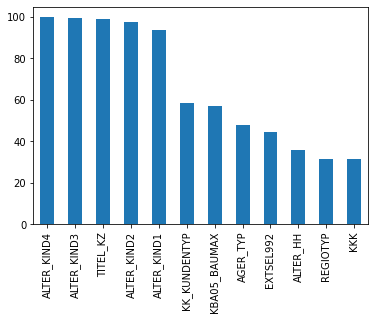

In [106]:
# Plot a graph
feature_customers[feature_customers.Missing_Percentage > 30].Missing_Percentage.plot(kind='bar');

In [107]:
# Apply function on datasets
feature_azdias = find_max_missing_features(azdias_new)
feature_azdias.head(15)

,Attribute,Missing_Percentage
ALTER_KIND4,13.0,99.86
TITEL_KZ,6.0,99.76
ALTER_KIND3,16.0,99.31
ALTER_KIND2,18.0,96.69
ALTER_KIND1,18.0,90.90
AGER_TYP,5.0,76.02
EXTSEL992,57.0,73.40
KK_KUNDENTYP,7.0,65.60
KBA05_BAUMAX,6.0,53.47
ALTER_HH,22.0,34.81


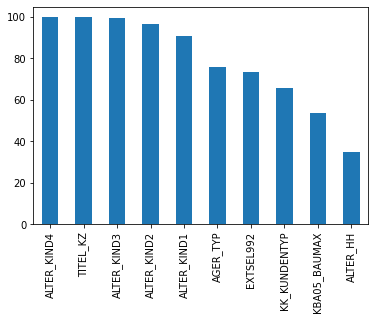

In [108]:
# Plot a graph
feature_azdias[feature_azdias.Missing_Percentage > 30].Missing_Percentage.plot(kind='bar');

#### To get a better understanding of missing values in both datasets, let's combine them for further analysis.

In [109]:
# Add a customer data in temp
temp_c = feature_customers.reset_index()
temp_c.rename(columns={'Attribute':'Value_Customer', 'Missing_Percentage':'Missing_Customers'}, inplace=True)
temp_c.head(15)

,index,Value_Customer,Missing_Customers
0,ALTER_KIND4,11.0,99.88
1,ALTER_KIND3,15.0,99.33
2,TITEL_KZ,5.0,98.79
3,ALTER_KIND2,18.0,97.34
4,ALTER_KIND1,18.0,93.86
5,KK_KUNDENTYP,7.0,58.41
6,KBA05_BAUMAX,6.0,57.15
7,AGER_TYP,5.0,48.06
8,EXTSEL992,57.0,44.50
9,ALTER_HH,21.0,35.87


In [110]:
# Add a azdias data in temp
temp_a = feature_azdias.reset_index()
temp_a.rename(columns={'Attribute':'Value_Azdias', 'Missing_Percentage':'Missing_azdias'}, inplace=True)
temp_a.head(15)

,index,Value_Azdias,Missing_azdias
0,ALTER_KIND4,13.0,99.86
1,TITEL_KZ,6.0,99.76
2,ALTER_KIND3,16.0,99.31
3,ALTER_KIND2,18.0,96.69
4,ALTER_KIND1,18.0,90.90
5,AGER_TYP,5.0,76.02
6,EXTSEL992,57.0,73.40
7,KK_KUNDENTYP,7.0,65.60
8,KBA05_BAUMAX,6.0,53.47
9,ALTER_HH,22.0,34.81


In [111]:
# Merge both temp datasets
merged_data = temp_c.merge(temp_a, on='index')
merged_data.head(15)

,index,Value_Customer,Missing_Customers,Value_Azdias,Missing_azdias
0,ALTER_KIND4,11.0,99.88,13.0,99.86
1,ALTER_KIND3,15.0,99.33,16.0,99.31
2,TITEL_KZ,5.0,98.79,6.0,99.76
3,ALTER_KIND2,18.0,97.34,18.0,96.69
4,ALTER_KIND1,18.0,93.86,18.0,90.90
5,KK_KUNDENTYP,7.0,58.41,7.0,65.60
6,KBA05_BAUMAX,6.0,57.15,6.0,53.47
7,AGER_TYP,5.0,48.06,5.0,76.02
8,EXTSEL992,57.0,44.50,57.0,73.40
9,ALTER_HH,21.0,35.87,22.0,34.81


In [112]:
# Find highest missing columns which are common in both datasets
common_cols = list(merged_data.loc[(merged_data['Missing_Customers'] > 30) & (merged_data['Missing_azdias'] > 30)]['index'])
common_cols

['ALTER_KIND4',
 'ALTER_KIND3',
 'TITEL_KZ',
 'ALTER_KIND2',
 'ALTER_KIND1',
 'KK_KUNDENTYP',
 'KBA05_BAUMAX',
 'AGER_TYP',
 'EXTSEL992',
 'ALTER_HH']

In [113]:
# Drop these columns from both datasets
azdias_new = azdias_new.drop(common_cols, axis = 1)
customers_new = customers_new.drop(common_cols, axis = 1)

In [114]:
# Check the shape of data after dropping columns
print("Shape of datasets after dropping columns:")
print(f"Customers: {customers_new.shape}")
print(f"Azdias: {azdias_new.shape}")

Shape of datasets after dropping columns:
Customers: (191652, 356)
Azdias: (891221, 356)


In [116]:
# Function to find missing rows
def missing_row_hist(df1, df2, bins=30, figsize=(10,6)):
    """
    This function plot a barchart comparing two dataframes for missing rows
    and percentage of missing values based on a threshold percentage given.
    
    Input:
    df1 - Dataframe to find missing rows
    df2 - Dataframe to find missing rows
    
    Output:
    None
    """
    bins = 30
    fig = plt.figure(figsize=figsize)

    ax = fig.add_subplot(111)
    ax.set_title("Features wise Missing Rows", fontsize = 14)
    ax.set_xlabel("Features", fontsize = 12)
    ax.set_ylabel("Number of Missing Rows", fontsize = 12)
    sns.distplot(df1.isnull().sum(axis=1), bins, kde=False, ax=ax, label="Azdias")
    sns.distplot(df2.isnull().sum(axis=1), bins, kde=False, ax=ax, label="Customers")
    ax.legend()
    
    plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


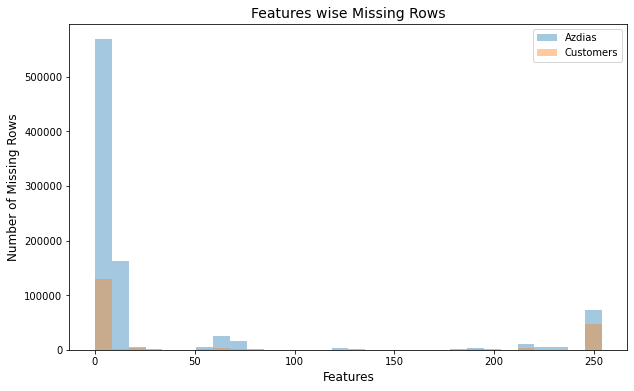

In [117]:
# Plot a graph
missing_row_hist(azdias_new, customers_new)

#### The figure shows that there are 250 features out 356 contains missing rows. The max missing rows in azdias dataset are more than 500000 and for customers dataset the count is greater that 100000. There are less than 50 missing values in both datasets.

In [118]:
# Function to drop missing rows
def drop_missing_rows(df, threshold):
    """
    This function drops rows with number of missing features as per the given threshold.
    
    Input:
    df - Dataframe to drop the missing rows
    threshold - Threshold to delete rows
    
    Output:
    df - The transformed dataframe
    """
    total_rows = df.shape[0]
    
    df = df.dropna(thresh=df.shape[1]-threshold)
    dropped_rows = total_rows - df.shape[0]
    
    # Reset index
    df = df.reset_index()
    del df['index']
    
    return df

In [119]:
# Apply the function
customers_new = drop_missing_rows(customers_new, threshold=50)
azdias_new = drop_missing_rows(azdias_new, threshold=50)

In [120]:
# Check the shape of data after dropping rows
print("Shape of datasets after dropping rows:")
print(f"Customers: {len(customers_new)}")
print(f"Azdias: {len(azdias_new)}")

Shape of datasets after dropping rows:
Customers: 134246
Azdias: 737288


#### We can start feature engineering from this point, since some columns have mixed information and some have too much information packed into one single column. We can address these issues by creating new features or modifying existing features to contain useful information.
1. `CAMEO_INTL_2015` into `CAMEO_INTL_2015_wealth_type` and `CAMEO_INTL_2015_family_type`
2. `LP_LEBENSPHASE_FEIN` into `LP_LEBENSPHASE_FEIN_family_type`, `LP_LEBENSPHASE_FEIN_earner_type`, `LP_LEBENSPHASE_FEIN_age_group`
3. `PRAEGENDE_JUGENDJAHRE` by movent type (avangard or mainstream) and decade

In [121]:
# Function to clean the data
def data_cleaning(df):
    '''
    This function deals with designated columns and imputes missing data. 
    
    Input: 
    df -  Dataframe to perform cleaning operation
    
    Output:
    None
    ''' 
    labelencoder = LabelEncoder()
   
    # CAMEO_INTL_2015
    cameo_wealth_type = {
        11:'Wealthy', 12:'Wealthy',13:'Wealthy', 14:'Wealthy', 15:'Wealthy', 
        21:'Prosperous', 22:'Prosperous', 23:'Prosperous', 24:'Prosperous', 25:'Prosperous',
        31:'Comfortable', 32:'Comfortable', 33:'Comfortable', 34:'Comfortable', 35:'Comfortable',
        41:'Less Affluent', 42:'Less Affluent', 43:'Less Affluent', 44:'Less Affluent', 45:'Less Affluent',
        51:'Poorer', 52:'Poorer', 53:'Poorer', 54:'Poorer', 55:'Poorer'
    }
    cameo_family_type = {
        11:'Pre-Family Couples & Singles',
        12:'Young Couples With Children',
        13:'Families With School Age Children',
        14:'Older Families &  Mature Couples',
        15:'Elders In Retirement',
        21:'Pre-Family Couples & Singles',
        22:'Young Couples With Children',
        23:'Families With School Age Children',
        24:'Older Families &  Mature Couples',
        25:'Elders In Retirement',
        31:'Pre-Family Couples & Singles',
        32:'Young Couples With Children',
        33:'Families With School Age Children',
        34:'Older Families &  Mature Couples',
        35:'Elders In Retirement',
        41:'Pre-Family Couples & Singles',
        42:'Young Couples With Children',
        43:'Families With School Age Children',
        44:'Older Families &  Mature Couples',
        45:'Elders In Retirement',
        51:'Pre-Family Couples & Singles',
        52:'Young Couples With Children',
        53:'Families With School Age Children',
        54:'Older Families &  Mature Couples',
        55:'Elders In Retirement',

    }
    
    # not in customers, but in azdias
    if 'CAMEO_INTL_2015' in df.columns:
        df['CAMEO_INTL_2015_wealth_type'] = df['CAMEO_INTL_2015'].map(cameo_wealth_type)
        df['CAMEO_INTL_2015_family_type'] = df['CAMEO_INTL_2015'].map(cameo_family_type)
    
    # LP_LEBENSPHASE_FEIN
    family_type_dict = {
        1: 'single', 2: 'single', 3: 'single', 4: 'single', 5: 'single', 6: 'single', 7: 'single',
        8: 'single', 9: 'single', 10:'single', 11:'single', 12:'single', 13:'single', 14:'couples',
        15:'couples', 16:'couples', 17:'couples', 18:'couples', 19:'couples', 20:'couples', 21:'single_parent',
        22:'single_parent', 23:'single_parent', 24:'families', 25:'families', 26:'families', 27:'families', 28:'families',
        29:'mulitperson_households', 30:'mulitperson_households', 31:'mulitperson_households', 32:'mulitperson_households',
        33:'mulitperson_households', 34:'mulitperson_households', 35:'mulitperson_households', 36:'mulitperson_households',
        37:'mulitperson_households', 38:'mulitperson_households', 39:'mulitperson_households', 40:'mulitperson_households'
    }
    earner_type_dict = {
        1: 'low', 2: 'low', 3: 'average', 4: 'average', 5: 'low', 6: 'low', 7: 'average',
        8: 'average', 9: 'independant', 10:'wealthy', 11:'homeowners', 12:'homeowners', 13:'top', 14:'low',
        15: 'low', 16:'average', 17: 'independant', 18:'wealthy', 19:'homeowners', 20:'top', 21:'low',
        22: 'average', 23:'high', 24:'low', 25:'average', 26: 'independant', 27:'homeowners', 28:'top',
        29: 'low', 30:'average', 31:'low', 32:'average',
        33: 'independant', 34:'homeowners', 35:'top', 36: 'independant',
        37: 'homeowners', 38:'homeowners', 39:'top', 40:'top'
    }
    age_group_dict = {
        1: 'younger_age', 2: 'middle_age', 3: 'younger_age', 4: 'middle_age', 5: 'advanced_age', 
        6: 'retirement_age', 7: 'advanced_age', 8: 'retirement_age', 9: np.nan, 10: np.nan, 
        11:'advanced_age', 12:'retirement_age', 13:'higher_age', 14:'younger_age', 15: 'higher_age', 
        16:'higher_age', 17: np.nan, 18:'younger_age', 19:'higher_age', 20:'higher_age', 
        21: np.nan, 22: np.nan, 23:np.nan, 24:np.nan, 25:np.nan, 
        26: np.nan, 27:np.nan, 28:np.nan, 29: 'younger_age', 30:'younger_age', 
        31:'higher_age', 32:'higher_age', 33: 'younger_age', 34:'younger_age', 35:'younger_age', 
        36: 'higher_age', 37: 'advanced_age', 38:'retirement_age', 39:'middle_age', 40:'retirement_age'
    }
    
    if 'LP_LEBENSPHASE_FEIN' in df.columns:
        df['LP_LEBENSPHASE_FEIN_family_type'] = df['LP_LEBENSPHASE_FEIN'].map(family_type_dict)
        df['LP_LEBENSPHASE_FEIN_earner_type'] = df['LP_LEBENSPHASE_FEIN'].map(earner_type_dict)
        df['LP_LEBENSPHASE_FEIN_age_group'] = df['LP_LEBENSPHASE_FEIN'].map(age_group_dict)
    
    # LP_FAMILIE_GROB
    family_type_dict = {
        1: 'single', 2: 'couple', 3: 'single_parent', 4: 'single_parent', 5: 'single_parent', 
        6: 'family', 7: 'family', 8: 'family', 9: 'mulitperson_households', 10: 'mulitperson_households', 
        11: 'mulitperson_households'
    }
    if 'LP_FAMILIE_GROB' in df.columns:
        df['LP_FAMILIE_GROB_family_type'] = df['LP_FAMILIE_GROB'].map(family_type_dict)
    
    # LP_STATUS_GROB
    earner_type_dict = {
        1: 'low', 2: 'low', 3: 'average', 4: 'average', 5: 'average', 
        6: 'independant', 7: 'independant', 8: 'houseowners', 9: 'houseowners', 10: 'top'
    }
    if 'LP_STATUS_GROB' in df.columns:
        df['LP_STATUS_GROB_earner_type'] = df['LP_STATUS_GROB'].map(earner_type_dict)
    
    
    # PRAEGENDE_JUGENDJAHRE
    movement_dict = {
        1: 'mainstream', 2: 'avantgarde', 3: 'mainstream', 4: 'avantgarde',
        5: 'mainstream', 6: 'avantgarde', 7: 'avantgarde', 8: 'mainstream', 9: 'avantgarde', 
        10: 'mainstream', 11: 'avantgarde', 12: 'mainstream', 13: 'avantgarde', 14: 'mainstream',
        15: 'avantgarde'
    }
    if 'PRAEGENDE_JUGENDJAHRE' in df.columns:
        df['PRAEGENDE_JUGENDJAHRE_movement'] = df['PRAEGENDE_JUGENDJAHRE'].map(movement_dict)
    
    decade_dict = {
        1: '40s', 2: '40s', 3: '50s', 4: '50s',
        5: '60s', 6: '60s', 7: '60s', 8: '70s', 9: '70s', 
        10: '80s', 11: '80s', 12: '80s', 13: '80s', 14: '90s',
        15: '90s'
    }
    if 'PRAEGENDE_JUGENDJAHRE' in df.columns:
        df['PRAEGENDE_JUGENDJAHRE_decade'] = df['PRAEGENDE_JUGENDJAHRE'].map(decade_dict)
    
    
    # not in customers, but in azdias
    if 'EINGEFUEGT_AM' in df.columns:
        df['EINGEFUEGT_AM'] = pd.to_datetime(df['EINGEFUEGT_AM']).dt.year
    
    list_of_obj_cols = ['CAMEO_INTL_2015', 'CAMEO_INTL_2015_wealth_type','CAMEO_INTL_2015_family_type',
                        'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_FEIN_family_type', 'LP_LEBENSPHASE_FEIN_earner_type', 
                        'LP_LEBENSPHASE_FEIN_age_group', 'LP_FAMILIE_GROB', 'LP_FAMILIE_GROB_family_type', 
                        'LP_STATUS_GROB', 'LP_STATUS_GROB_earner_type', 'PRAEGENDE_JUGENDJAHRE', 
                        'PRAEGENDE_JUGENDJAHRE_movement', 'PRAEGENDE_JUGENDJAHRE_decade', 'EINGEFUEGT_AM',
                        'CAMEO_INTL_2015', 'OST_WEST_KZ', 'CAMEO_DEU_2015', 'PRODUCT_GROUP', 'CUSTOMER_GROUP', 
                        'D19_LETZTER_KAUF_BRANCHE']
   
    # imputing with most frequent
    for col in df.columns:
        if col in list_of_obj_cols:
            df[col].fillna(df[col].value_counts().idxmax(), inplace=True)
        else: 
            print(col)
            df[col].fillna(df[col].median(), inplace=True)

    
    # label encoding
    
    if 'CAMEO_INTL_2015' in df.columns:
        df['CAMEO_INTL_2015_wealth_type'] = labelencoder.fit_transform(df['CAMEO_INTL_2015_wealth_type'])
        df['CAMEO_INTL_2015_family_type'] = labelencoder.fit_transform(df['CAMEO_INTL_2015_family_type'])
    
    if 'LP_LEBENSPHASE_FEIN_family_type' in df.columns:
        df['LP_LEBENSPHASE_FEIN_family_type'] = labelencoder.fit_transform(df['LP_LEBENSPHASE_FEIN_family_type'])
        df['LP_LEBENSPHASE_FEIN_earner_type'] = labelencoder.fit_transform(df['LP_LEBENSPHASE_FEIN_earner_type'])
        df['LP_LEBENSPHASE_FEIN_age_group'] = labelencoder.fit_transform(df['LP_LEBENSPHASE_FEIN_age_group'])

    
    if 'LP_LEBENSPHASE_FEIN_family_type' in df.columns:
        df['LP_FAMILIE_GROB_family_type'] = labelencoder.fit_transform(df['LP_FAMILIE_GROB_family_type'])

    
    if 'LP_LEBENSPHASE_FEIN_family_type' in df.columns:
        df['LP_STATUS_GROB_earner_type'] = labelencoder.fit_transform(df['LP_STATUS_GROB_earner_type'])

    drop_cols = ['LP_LEBENSPHASE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_GROB', 'PRAEGENDE_JUGENDJAHRE', 
                 'CAMEO_INTL_2015', 'D19_LETZTER_KAUF_BRANCHE']
    
    df.drop(drop_cols, axis = 1, inplace = True, errors='ignore')
    
    # OST_WEST_KZ
    if 'OST_WEST_KZ' in df.columns:
        df['OST_WEST_KZ'] = labelencoder.fit_transform(df['OST_WEST_KZ'])
        
    
    # CAMEO_DEU_2015
    if 'CAMEO_DEU_2015' in df.columns:
        df['CAMEO_DEU_2015'] = labelencoder.fit_transform(df['CAMEO_DEU_2015'])
    
    
    for value in ['PRODUCT_GROUP', 'CUSTOMER_GROUP']:
        if value in df.columns:
            df[value] = labelencoder.fit_transform(df[value])
            
    if 'PRAEGENDE_JUGENDJAHRE_movement' in df.columns:   
        df['PRAEGENDE_JUGENDJAHRE_movement'] = labelencoder.fit_transform(df['PRAEGENDE_JUGENDJAHRE_movement'])
        df['PRAEGENDE_JUGENDJAHRE_decade'] = labelencoder.fit_transform(df['PRAEGENDE_JUGENDJAHRE_decade'])


In [122]:
# Apply function
customers_clean = data_cleaning(customers_new)
azdias_clean = data_cleaning(azdias_new)

LNR
AKT_DAT_KL
ALTERSKATEGORIE_FEIN
ANZ_HAUSHALTE_AKTIV
ANZ_HH_TITEL
ANZ_KINDER
ANZ_PERSONEN
ANZ_STATISTISCHE_HAUSHALTE
ANZ_TITEL
ARBEIT
BALLRAUM
CAMEO_DEUG_2015
CJT_GESAMTTYP
CJT_KATALOGNUTZER
CJT_TYP_1
CJT_TYP_2
CJT_TYP_3
CJT_TYP_4
CJT_TYP_5
CJT_TYP_6
D19_BANKEN_ANZ_12
D19_BANKEN_ANZ_24
D19_BANKEN_DATUM
D19_BANKEN_DIREKT
D19_BANKEN_GROSS
D19_BANKEN_LOKAL
D19_BANKEN_OFFLINE_DATUM
D19_BANKEN_ONLINE_DATUM
D19_BANKEN_ONLINE_QUOTE_12
D19_BANKEN_REST
D19_BEKLEIDUNG_GEH
D19_BEKLEIDUNG_REST
D19_BILDUNG
D19_BIO_OEKO
D19_BUCH_CD
D19_DIGIT_SERV
D19_DROGERIEARTIKEL
D19_ENERGIE
D19_FREIZEIT
D19_GARTEN
D19_GESAMT_ANZ_12
D19_GESAMT_ANZ_24
D19_GESAMT_DATUM
D19_GESAMT_OFFLINE_DATUM
D19_GESAMT_ONLINE_DATUM
D19_GESAMT_ONLINE_QUOTE_12
D19_HANDWERK
D19_HAUS_DEKO
D19_KINDERARTIKEL
D19_KONSUMTYP
D19_KONSUMTYP_MAX
D19_KOSMETIK
D19_LEBENSMITTEL
D19_LOTTO
D19_NAHRUNGSERGAENZUNG
D19_RATGEBER
D19_REISEN
D19_SAMMELARTIKEL
D19_SCHUHE
D19_SONSTIGE
D19_SOZIALES
D19_TECHNIK
D19_TELKO_ANZ_12
D19_TELKO_ANZ_24
D19_TELK

In [123]:
# Check the shape of data after performing cleaning operation
print("Shape of datasets after cleaning:")
print(f"Customers: {customers_clean.shape}")
print(f"Azdias: {azdias_clean.shape}")

Shape of datasets after dropping columns:
Customers: (134246, 359)
Azdias: (737288, 359)


In [124]:
# Save the cleaned datasets
azdias_clean.to_csv('E:\\udct\\Arvato Project\\azdias_clean.csv', index=False)
customers_clean.to_csv('E:\\udct\\Arvato Project\\customers_clean.csv', index=False)

#### After cleaning the data, we can scale it to make sure all the features have the same range. Let's use StandardScaler from sklearn to scale the data.

In [129]:
# Scale the data
scalar = StandardScaler()
scalar.fit(azdias_clean)

azdias_clean = pd.DataFrame(scalar.transform(azdias_clean), columns = azdias_clean.columns)
customers_clean = pd.DataFrame(scalar.transform(customers_clean), columns = customers_clean.columns)

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

#### Principal Component Analysis (PCA)
PCA is used to reduce the dimension of the data with minimum loss of information. As we have around 360 columns in our dataset, it will be easier to perform unsupervised analysis on reduced dimensions.

In [131]:
# PCA
pca = PCA(random_state=123)
azdias_pca = pca.fit_transform(azdias_clean)

In [132]:
# Number of components required to maintain 80% variance:
n_components = min(np.where(np.cumsum(pca.explained_variance_ratio_)>0.8)[0]+1)
n_components

123

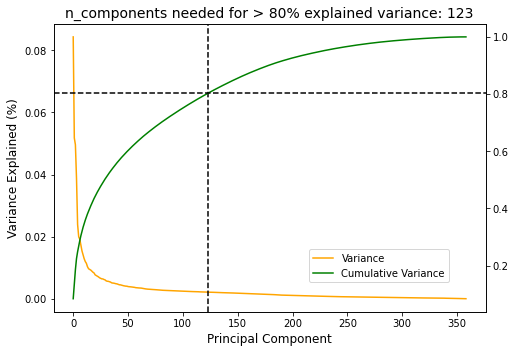

In [134]:
# Plot a graph of principanl component w.r.t variance explained
fig = plt.figure()
ax1 = fig.add_axes([0,0,1,1],True)
ax2 = ax1.twinx()
ax1.plot(pca.explained_variance_ratio_, label='Variance', color = 'orange')
ax2.plot(np.cumsum(pca.explained_variance_ratio_), label='Cumulative Variance',color = 'Green');
ax1.set_xlabel("Principal Component", fontsize = 12)
ax1.set_ylabel("Variance Explained (%)", fontsize = 12)
ax1.set_title('n_components needed for > 80% explained variance: {}'.format(n_components), fontsize = 14);
ax1.axvline(n_components, linestyle='dashed', color='black')
ax2.axhline(np.cumsum(pca.explained_variance_ratio_)[n_components], linestyle='dashed', color='black')
fig.legend(loc=(0.6,0.2))

#### The graph shows that around 123 components explain 80% of variance in the dataset. Let's see the feature importances for each component to understand what each PCA component represents.

In [138]:
# Function to print important features
def print_important_features(features, components, i):
    '''
    This function prints important features of PCA
    
    Input: 
    feature - The columns in the dataframe 
    components - The PCA components
    
    Output:      
    None  
    '''
    feature_weights = dict(zip(features, components[i]))
    feature_weights_sorted = sorted(feature_weights.items(), key=lambda kv: kv[1])
    print('Lowest:')
    for feature, weight in feature_weights_sorted[:5]:
        print('\t{:20} \t{:.3f}'.format(feature, weight))
        
    print('Highest:')
    for feature, weight in feature_weights_sorted[-5:]:
        print('\t{:20} \t{:.3f}'.format(feature, weight))

In [139]:
# First principal component
i = 1
print('{:5.2%}'.format(pca.explained_variance_ratio_[i]))
print("PCA 1")

print_important_features(azdias_clean.columns.values, pca.components_, i) 

5.18%
PCA 1
Lowest:
	D19_GESAMT_ONLINE_DATUM 	-0.132
	D19_VERSAND_ONLINE_DATUM 	-0.127
	D19_GESAMT_DATUM     	-0.126
	D19_VERSAND_DATUM    	-0.124
	FINANZ_VORSORGER     	-0.121
Highest:
	D19_VERSAND_ANZ_24   	0.124
	PRAEGENDE_JUGENDJAHRE_decade 	0.126
	D19_GESAMT_ANZ_12    	0.129
	D19_GESAMT_ANZ_24    	0.137
	ONLINE_AFFINITAET    	0.144


#### Component 1 is determined by online affinity, a dominating movement in the person's youth, and the person's financial behavior.

In [146]:
# Second principal component
i = 2
print('{:5.2%}'.format(pca.explained_variance_ratio_[i]))
print("PCA 2")

print_important_features(azdias_clean.columns.values, pca.components_, i)

4.96%
PCA 2
Lowest:
	KBA13_SITZE_5        	-0.136
	KBA13_SEG_KLEINWAGEN 	-0.115
	KBA13_KMH_140_210    	-0.114
	KBA13_HALTER_20      	-0.109
	KBA13_HALTER_25      	-0.105
Highest:
	KBA13_SITZE_4        	0.134
	KBA13_BMW            	0.138
	KBA13_MERCEDES       	0.139
	KBA13_SEG_OBEREMITTELKLASSE 	0.143
	KBA13_HERST_BMW_BENZ 	0.163


#### Component 2 is determined by number of cars, and numbers of shares of small and upper class cars. 
Higher component relates to higher probability of people have shares of upper class cars(i.e BMW, MERCEDES). So, people who hold more and belongs to upper class and middle class are likey to become mail-order company's customer.

In [147]:
# Third principal component
i = 3
print('{:5.2%}'.format(pca.explained_variance_ratio_[i]))
print("PCA 3")

print_important_features(azdias_clean.columns.values, pca.components_, i)

3.88%
PCA 3
Lowest:
	PRAEGENDE_JUGENDJAHRE_decade 	-0.149
	FINANZ_SPARER        	-0.148
	FINANZ_ANLEGER       	-0.147
	CJT_TYP_1            	-0.145
	FINANZ_UNAUFFAELLIGER 	-0.144
Highest:
	CJT_TYP_4            	0.110
	CJT_TYP_3            	0.113
	CJT_TYP_5            	0.126
	ALTERSKATEGORIE_GROB 	0.130
	FINANZ_VORSORGER     	0.135


#### Component 3 is determined by financial topology, person's age, and money savers.
Higher component relates to higher probability of people being older in age, money savers and crazy shopper are likely to become mail-order company's customer.

#### K-Means
Let's use the K-Means Clustering algorithm to cluster the general population into different segments.

   Centroids         Score
0         30  1.551900e+07
1         25  1.676203e+07
2         22  1.769625e+07
3         20  1.842470e+07
4         15  2.091128e+07
5         11  2.391628e+07
6         10  2.492669e+07
7          5  3.445664e+07
8          2  4.985598e+07


Text(0, 0.5, 'Sum of Squared Errors')

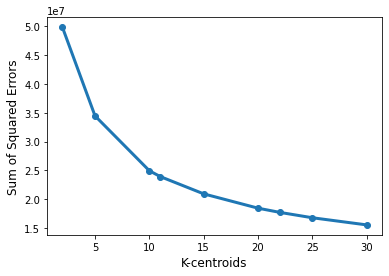

In [149]:
# Function to calculate K-Means score for a centroid
def elbow_method(data, center):
    '''
    This function calculates the K-Means score for a centroid
    
    Input:
    data - Dataframe with reduced dimentions
    center - The centroids
    
    Output:
    score - The score of centroid
    '''
    kmeans = KMeans(n_clusters = center, n_init=10, max_iter=300, random_state=42)
    model = kmeans.fit(data)
    score = np.abs(model.score(data))
    
    return score

# Run possible number of cluster centroid through K-means score function
score_pca = []
centroids = [2,5,10,11,15,20,22,25,30]

for x in centroids:
    score_pca.append(elbow_method(azdias_pca[:,:5],x))
    
# Print score report
print(pd.DataFrame(sorted(zip(centroids, score_pca), key=lambda x: x[1]), columns=['Centroids','Score']))

# Plot a graph
plt.plot(centroids,score_pca, linestyle='-', linewidth=3, marker='o')
plt.xlabel('K-centroids', fontsize = 12)
plt.ylabel('Sum of Squared Errors', fontsize = 12)

#### The plot shows that the error rate is decreasing less gradually after 10 clusters. As a result, we choose 10 as our final cluster number.

In [152]:
# Perform pipeline for a selected cluster
n_clusters = 10
cluster_p = Pipeline([
                        ('pca', PCA(n_components)),
                        ('kmeans', KMeans(n_clusters=n_clusters, random_state=42) )
                    ])

In [153]:
# Predict the cluster for dataset
cluster_p.fit(azdias_clean)
azdias_predict = cluster_p.predict(azdias_clean)
azdias_predict[:10]

array([2, 2, 1, 7, 1, 2, 2, 5, 5, 3])

In [154]:
# calculate the percentage and count covered by the cluster of the azdias data
azdias_cluster = pd.Series(azdias_predict).value_counts().reset_index()
azdias_cluster.columns   = ['Cluster', 'Count']
azdias_cluster['Dataset'] = 'Azdias'
azdias_cluster['Percentage']  = azdias_cluster['Count'] / azdias_clean.shape[0]

In [155]:
azdias_cluster.head()

,Cluster,Count,Dataset,Percentage
0,2,102742,Azdias,0.139351
1,6,94685,Azdias,0.128423
2,1,94385,Azdias,0.128016
3,3,93217,Azdias,0.126432
4,8,76843,Azdias,0.104224


In [156]:
# Predict the cluster for dataset
customers_predict = cluster_p.predict(customers_clean)
customers_predict[:10]

array([5, 3, 1, 7, 5, 6, 5, 9, 5, 6])

In [157]:
# calculate the percentage and count covered by the cluster of the customers data
customers_cluster = pd.Series(customers_predict).value_counts().reset_index()
customers_cluster.columns   = ['Cluster', 'Count']
customers_cluster['Dataset'] = 'Customers'
customers_cluster['Percentage']  = customers_cluster['Count'] / customers_clean.shape[0]

In [158]:
customers_cluster.head()

,Cluster,Count,Dataset,Percentage
0,5,43913,Customers,0.327108
1,6,29414,Customers,0.219105
2,1,26719,Customers,0.199030
3,3,15529,Customers,0.115676
4,9,6273,Customers,0.046728


In [159]:
# Find the difference in the clusters for both datasets
Cluster_Diff_Perc = pd.concat([azdias_cluster.groupby(['Cluster']).agg({'Percentage': ['sum']}), 
                      customers_cluster.groupby(['Cluster']).agg({'Percentage': ['sum']}) ], axis = 1)

Cluster_Diff_Perc.columns = ['Azdias', 'Customers']
Cluster_Diff_Perc['Difference'] = Cluster_Diff_Perc['Customers'] - Cluster_Diff_Perc['Azdias']
Cluster_Diff_Perc.head()

,Azdias,Customers,Difference
Cluster,,,
0,0.062343,0.024276,-0.038067
1,0.128016,0.199030,0.071014
2,0.139351,0.007948,-0.131403
3,0.126432,0.115676,-0.010757
4,0.070031,0.020127,-0.049904


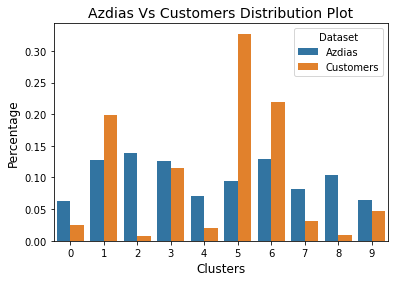

In [161]:
# Comparision of the percentage of customer data to the azdias.
Dataset_Diff = pd.concat([azdias_cluster, customers_cluster], axis = 0, sort = True) 
fig = plt.figure()
sns.barplot(x = 'Cluster', y = 'Percentage', hue = 'Dataset', data = Dataset_Diff)
plt.title("Azdias Vs Customers Distribution Plot", fontsize = 14)
plt.xlabel("Clusters", fontsize = 12)
plt.ylabel("Percentage", fontsize = 12)
plt.show()

#### Based on cluster distribution histogram on both datasets, it is clear to see that Cluster 5 is outstanding for customers, which means people in this group are more likely to be part of the mail-order company’s main customer base than other groups.
Also, we noticed following characteristics of such people:
1. Financially Capable or good
2. Holds higher number of shares
3. Higher online/transaction activities or crazy shopper
4. Older in age
5. Money savers

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [297]:
# Load the data
mailout_train = pd.read_csv('E:\\udct\\Arvato Project\\Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [298]:
mailout_train.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


In [299]:
# Check the shape of data
print(mailout_train.shape)

(42962, 367)


In [300]:
# Find out the uniqueness in the data
unique_cols_a = list(set(customers.columns.values) - set(mailout_train.columns.values))
unique_cols_b = list(set(mailout_train.columns.values) - set(azdias.columns.values))

print("Rows in customers set that are not in mailout: " + str(unique_cols_a))
print("Rows in mailout set that are not in azdias: " + str(unique_cols_b))

Rows in customers set that are not in mailout: ['PRODUCT_GROUP', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE']
Rows in mailout set that are not in azdias: ['RESPONSE']


#### Data Pre-processing

In [301]:
# Function to clean the data to use it for supervised model
def data_cleaning_supervised_model(df):
    '''
    This function prepares the MAILOUT_TRAIN dataset for training under the supervised model. 
    
    Input: 
    df -  Dataframe to perform cleaning operation
    
    Output
    df - The transformed dataframe
    '''
    print('Format mixed-types \n')      
    df = fix_cameo(df)
    
    print('Replace unknowns \n')   
    replace_unknown(df, dict_unknown)
    additional_missing_values = {'KBA05_MODTEMP': [6.0], 'LP_FAMILIE_FEIN': [0.0], 'LP_FAMILIE_GROB': [0.0],
                                 'LP_LEBENSPHASE_FEIN': [0.0], 'LP_LEBENSPHASE_GROB': [0.0], 'ORTSGR_KLS9': [0.0], 
                                 'GEBURTSJAHR': [0]}
    
    replace_unknown(df, additional_missing_values)
    
    data_cleaning(df)
    
    return df

In [302]:
# Apply the function
mailout_train_clean = data_cleaning_supervised_model(mailout_train)

Format mixed-types 

Replace unknowns 

LNR
AGER_TYP
AKT_DAT_KL
ALTER_HH
ALTER_KIND1
ALTER_KIND2
ALTER_KIND3
ALTER_KIND4
ALTERSKATEGORIE_FEIN
ANZ_HAUSHALTE_AKTIV
ANZ_HH_TITEL
ANZ_KINDER
ANZ_PERSONEN
ANZ_STATISTISCHE_HAUSHALTE
ANZ_TITEL
ARBEIT
BALLRAUM
CAMEO_DEUG_2015
CJT_GESAMTTYP
CJT_KATALOGNUTZER
CJT_TYP_1
CJT_TYP_2
CJT_TYP_3
CJT_TYP_4
CJT_TYP_5
CJT_TYP_6
D19_BANKEN_ANZ_12
D19_BANKEN_ANZ_24
D19_BANKEN_DATUM
D19_BANKEN_DIREKT
D19_BANKEN_GROSS
D19_BANKEN_LOKAL
D19_BANKEN_OFFLINE_DATUM
D19_BANKEN_ONLINE_DATUM
D19_BANKEN_ONLINE_QUOTE_12
D19_BANKEN_REST
D19_BEKLEIDUNG_GEH
D19_BEKLEIDUNG_REST
D19_BILDUNG
D19_BIO_OEKO
D19_BUCH_CD
D19_DIGIT_SERV
D19_DROGERIEARTIKEL
D19_ENERGIE
D19_FREIZEIT
D19_GARTEN
D19_GESAMT_ANZ_12
D19_GESAMT_ANZ_24
D19_GESAMT_DATUM
D19_GESAMT_OFFLINE_DATUM
D19_GESAMT_ONLINE_DATUM
D19_GESAMT_ONLINE_QUOTE_12
D19_HANDWERK
D19_HAUS_DEKO
D19_KINDERARTIKEL
D19_KONSUMTYP
D19_KONSUMTYP_MAX
D19_KOSMETIK
D19_LEBENSMITTEL
D19_LOTTO
D19_NAHRUNGSERGAENZUNG
D19_RATGEBER
D19_REISEN
D19

In [303]:
# Drop the columns which are not required
drop_cols = ['ALTER_KIND4','ALTER_KIND3','TITEL_KZ','ALTER_KIND2','ALTER_KIND1',
                 'KK_KUNDENTYP','KBA05_BAUMAX','AGER_TYP','EXTSEL992','ALTER_HH']

mailout_train_clean = mailout_train_clean.drop(drop_cols, axis = 1)

In [304]:
# Check the shape of cleaned data
mailout_train_clean.shape

(42962, 360)

0    42430
1      532
Name: RESPONSE, dtype: int64
0    0.987617
1    0.012383
Name: RESPONSE, dtype: float64


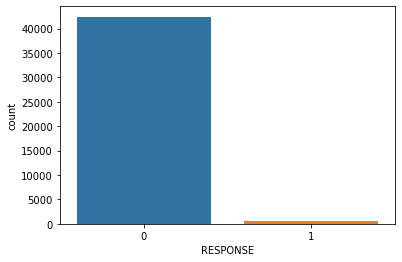

In [305]:
# Inspect the column response
print(mailout_train_clean.RESPONSE.value_counts())
print(mailout_train_clean.RESPONSE.value_counts() / np.sum(mailout_train_clean.RESPONSE.value_counts()))
sns.countplot(x = "RESPONSE", data=mailout_train);

The data is highly imbalanced. We have more thn 40k - 0 responses and only 532 - 1 responses. So, even if the model predicts zero for all the data points we will end up with having accuracy 98.7% which does not make sense in this case.

To address this imbalance while evaluating the model we need to chose a metric which will take this class imbalance into accounts. The usual metrics used for imbalanced classification are Precision and Recall or or Area under Receiver Operating Curve (AUROC).

#### Let's train a model on unscaled data to check performance of various models.

In [306]:
X_train = mailout_train_clean.iloc[:, mailout_train_clean.columns != 'RESPONSE']
y_train = mailout_train_clean['RESPONSE']

In [307]:
# Scale the data
scaler_model = StandardScaler()
X_train = scaler_model.fit_transform(X_train)

In [308]:
# Split the dataset into Train and Test set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [309]:
# Function to fit the method
def train_model(model, X_train, y_train, X_val, y_val):
    '''
    This function is the customization of the fit method.
    
    Input: 
    model - The model from the list of the classifiers/models
    X_train - The training data
    y_train - The training labels
    X_val - The validation of data
    y_val - The validation of labels
    
    Output: 
    ROC-AUC score 
    Training time
    '''
    t = time.time()
    model = model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_val)[:,1]
    
    roc_score = roc_auc_score(y_val, y_pred)

    train_time = time.time() - t
    
    return roc_score, train_time 

In [310]:
# Models to check for performance
models = [("LogisticRegression", LogisticRegression(random_state=42)),
         ("DecisionTreeClassifier", DecisionTreeClassifier(random_state=42)),
         ("RandomForestClassifier", RandomForestClassifier(random_state=42)),
         ("GradientBoostingClassifier", GradientBoostingClassifier(random_state=42)),
         ("AdaBoostClassifier", AdaBoostClassifier(random_state=42)),
         ("XGBClassifier",xgb.XGBClassifier(random_state=42))]

In [311]:
# Function to iterate over classifier and fir method
def test_model(classifiers, X_train, y_train, X_val, y_val):
    '''
    This function iterates over declared classifiers and calls the custom fit method.
    
    Input: 
    classifiers - The list of the classifiers/models
    X_train - The training data
    y_train - The training labels
    X_val - The validation data
    y_val - The validation labels
    
    Output: 
    df - The resulting dataframe for comparison
    '''
    result={
    'Classifier':[],
    'Score':[],
    'Train Time':[]
    }
    
    for name, classifier in classifiers:
        score, t = train_model(classifier, X_train, y_train, X_val, y_val)
        result['Classifier'].append(name)
        result['Score'].append(score)
        result['Train Time'].append(t)
    
    results_df = pd.DataFrame.from_dict(result, orient='index').transpose()
    
    return results_df

In [312]:
# Apply the function
test_model(models, X_train, y_train, X_val, y_val)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:55:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,Classifier,Score,Train Time
0,LogisticRegression,0.663947,1.52789
1,DecisionTreeClassifier,0.520014,3.741404
2,RandomForestClassifier,0.594675,13.891999
3,GradientBoostingClassifier,0.745092,112.122969
4,AdaBoostClassifier,0.723016,25.895756
5,XGBClassifier,0.654841,22.680465


#### The above table shows that the GradientBoostingClassifier has the highest score, but it is the slowest to train. The AdaBoostClasifier have the next highest score and also took less time to train. So, let's select these algorithms for hyper parameter tuning.

### Grid Search

#### GradientBoostClassifier

In [369]:
# Grid serach for GradientBoostClassifier model
gbc = GradientBoostingClassifier(random_state=42)

parameters = {'learning_rate': [0.1, 0.2], 
              'n_estimators': [100],
              'max_depth': [3, 5], 
              'min_samples_split': [2, 4]
             } 

In [317]:
# Fit the grid search object to the training data and find the optimal parameters
gbc_grid = GridSearchCV(gbc, parameters, scoring = 'roc_auc', verbose=10)

gbc_grid.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5; 1/8] START learning_rate=0.1, max_depth=3, min_samples_split=2, n_estimators=100
[CV 1/5; 1/8] END learning_rate=0.1, max_depth=3, min_samples_split=2, n_estimators=100;, score=0.801 total time= 1.5min
[CV 2/5; 1/8] START learning_rate=0.1, max_depth=3, min_samples_split=2, n_estimators=100
[CV 2/5; 1/8] END learning_rate=0.1, max_depth=3, min_samples_split=2, n_estimators=100;, score=0.710 total time= 1.5min
[CV 3/5; 1/8] START learning_rate=0.1, max_depth=3, min_samples_split=2, n_estimators=100
[CV 3/5; 1/8] END learning_rate=0.1, max_depth=3, min_samples_split=2, n_estimators=100;, score=0.748 total time= 1.5min
[CV 4/5; 1/8] START learning_rate=0.1, max_depth=3, min_samples_split=2, n_estimators=100
[CV 4/5; 1/8] END learning_rate=0.1, max_depth=3, min_samples_split=2, n_estimators=100;, score=0.755 total time= 1.5min
[CV 5/5; 1/8] START learning_rate=0.1, max_depth=3, min_samples_split=2, n_estimators=100
[CV 5/

GridSearchCV(estimator=GradientBoostingClassifier(random_state=42),
             param_grid={'learning_rate': [0.1, 0.2], 'max_depth': [3, 5],
                         'min_samples_split': [2, 4], 'n_estimators': [100]},
             scoring='roc_auc', verbose=10)

In [318]:
# Get the estimator and predict
print("Best Score: ", gbc_grid.best_score_)
print("Best Params: ", gbc_grid.best_params_)
best_clf = gbc_grid.best_estimator_
best_predictions = best_clf.predict_proba(X_train)[:, 1]

# Make predictions using unoptimized and the best model
predictions = (gbc.fit(X_train, y_train)).predict_proba(X_train)[:, 1]

print("ROC score: {:.4f}".format(roc_auc_score(y_train, predictions)))
print("Final ROC score: {:.4f}".format(roc_auc_score(y_train, best_predictions)))

Best Score:  0.7531651682793756
Best Params:  {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 4, 'n_estimators': 100}
ROC score: 0.9103
Final ROC score: 0.9074


#### AdaBoostClassifier

In [324]:
model = AdaBoostClassifier()
model.get_params().keys()

dict_keys(['algorithm', 'base_estimator', 'learning_rate', 'n_estimators', 'random_state'])

In [329]:
# Grid serach for AdaBoostClassifier model
abc = AdaBoostClassifier(random_state=42)

parameters = {'n_estimators':[50],
              'random_state': [42], 
             }

In [330]:
# Fit the grid search object to the training data and find the optimal parameters
abc_grid = GridSearchCV(abc, parameters, scoring = 'roc_auc', verbose=5)

abc_grid.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END ..n_estimators=50, random_state=42;, score=0.761 total time=  20.3s
[CV 2/5] END ..n_estimators=50, random_state=42;, score=0.672 total time=  20.0s
[CV 3/5] END ..n_estimators=50, random_state=42;, score=0.688 total time=  20.1s
[CV 4/5] END ..n_estimators=50, random_state=42;, score=0.709 total time=  20.0s
[CV 5/5] END ..n_estimators=50, random_state=42;, score=0.715 total time=  20.1s


GridSearchCV(estimator=AdaBoostClassifier(random_state=42),
             param_grid={'n_estimators': [50], 'random_state': [42]},
             scoring='roc_auc', verbose=5)

In [331]:
# Get the estimator and predict
print("Best Score: ", abc_grid.best_score_)
print("Best Params: ", abc_grid.best_params_)
best_clf = abc_grid.best_estimator_
best_predictions = best_clf.predict_proba(X_train)[:, 1]

# Make predictions using unoptimized and the best model
predictions = (abc.fit(X_train, y_train)).predict_proba(X_train)[:, 1]

print("ROC score: {:.4f}".format(roc_auc_score(y_train, predictions)))
print("Final ROC score: {:.4f}".format(roc_auc_score(y_train, best_predictions)))

Best Score:  0.7088097731981077
Best Params:  {'n_estimators': 50, 'random_state': 42}
ROC score: 0.9103
Final ROC score: 0.8408


#### After fine tuning the classifiers, using ROC as a scoring metric, we've observed that the performance of the GradientBoost have been improved. Therefore GradientBoost will be used for the final test data set for the Kaggle competition.

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter.

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [351]:
# Load the data
mailout_test = pd.read_csv('E:\\udct\\Arvato Project\\Udacity_MAILOUT_052018_TEST.csv', sep=';')

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [352]:
# Check the shape of the data
mailout_test.shape

(42833, 366)

In [353]:
# Perform data cleaning
mailout_test_clean = data_cleaning_supervised_model(mailout_test)

Format mixed-types 

Replace unknowns 

LNR
AGER_TYP
AKT_DAT_KL
ALTER_HH
ALTER_KIND1
ALTER_KIND2
ALTER_KIND3
ALTER_KIND4
ALTERSKATEGORIE_FEIN
ANZ_HAUSHALTE_AKTIV
ANZ_HH_TITEL
ANZ_KINDER
ANZ_PERSONEN
ANZ_STATISTISCHE_HAUSHALTE
ANZ_TITEL
ARBEIT
BALLRAUM
CAMEO_DEUG_2015
CJT_GESAMTTYP
CJT_KATALOGNUTZER
CJT_TYP_1
CJT_TYP_2
CJT_TYP_3
CJT_TYP_4
CJT_TYP_5
CJT_TYP_6
D19_BANKEN_ANZ_12
D19_BANKEN_ANZ_24
D19_BANKEN_DATUM
D19_BANKEN_DIREKT
D19_BANKEN_GROSS
D19_BANKEN_LOKAL
D19_BANKEN_OFFLINE_DATUM
D19_BANKEN_ONLINE_DATUM
D19_BANKEN_ONLINE_QUOTE_12
D19_BANKEN_REST
D19_BEKLEIDUNG_GEH
D19_BEKLEIDUNG_REST
D19_BILDUNG
D19_BIO_OEKO
D19_BUCH_CD
D19_DIGIT_SERV
D19_DROGERIEARTIKEL
D19_ENERGIE
D19_FREIZEIT
D19_GARTEN
D19_GESAMT_ANZ_12
D19_GESAMT_ANZ_24
D19_GESAMT_DATUM
D19_GESAMT_OFFLINE_DATUM
D19_GESAMT_ONLINE_DATUM
D19_GESAMT_ONLINE_QUOTE_12
D19_HANDWERK
D19_HAUS_DEKO
D19_KINDERARTIKEL
D19_KONSUMTYP
D19_KONSUMTYP_MAX
D19_KOSMETIK
D19_LEBENSMITTEL
D19_LOTTO
D19_NAHRUNGSERGAENZUNG
D19_RATGEBER
D19_REISEN
D19

In [360]:
# Drop the columns which are not required
drop_cols = ['ALTER_KIND4','ALTER_KIND3','TITEL_KZ','ALTER_KIND2','ALTER_KIND1',
                 'KK_KUNDENTYP','KBA05_BAUMAX','AGER_TYP','EXTSEL992','ALTER_HH']

mailout_test_clean = mailout_test_clean.drop(drop_cols, axis = 1)

In [361]:
# Check the shape of the data
mailout_test_clean.shape

(42833, 359)

In [364]:
# Scale the data
mailout_test_clean = scaler_model.fit_transform(mailout_test_clean)

In [365]:
# Predict the model
predict_proba = gbc_best.predict_proba(mailout_test_clean)
predict_proba

array([[0.97767981, 0.02232019],
       [0.98700496, 0.01299504],
       [0.99810962, 0.00189038],
       ...,
       [0.98372151, 0.01627849],
       [0.97778084, 0.02221916],
       [0.97482435, 0.02517565]])

In [368]:
# Generate data for the competition
result = pd.DataFrame({'LNR':mailout_test.LNR, 'RESPONSE':predict_proba[:,1]})
result.head(10)

,LNR,RESPONSE
0,1754,0.022320
1,1770,0.012995
2,1465,0.001890
3,1470,0.001841
4,1478,0.001200
5,1782,0.002900
6,1485,0.004282
7,1519,0.016915
8,1835,0.009339
9,1522,0.001887


In [370]:
result.to_csv('E:\\udct\\Arvato Project\\Arvato_Capstone_Submission.csv')